## Self-RAG

This notebook implements Self-RAG (Self-Reflective Retrieval-Augmented Generation), which combines:
- Document relevance grading
- Hallucination detection
- Answer completeness checking
- Query rewriting for better retrieval

Flow:
1. Query -> Retrieve -> Grade documents
2. If relevant -> Generate -> Check hallucinations -> Check answer quality
3. If not relevant -> Transform query -> Retrieve again
4. If hallucinations -> Regenerate
5. If doesn't answer query -> Transform query -> Retrieve again

In [1]:
from typing_extensions import TypedDict
from typing import Dict
import os

from langgraph.graph import StateGraph, START, END
from langchain_ollama import ChatOllama, OllamaEmbeddings
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_chroma import Chroma
from pydantic import BaseModel, Field

from scripts import my_tools

from dotenv import load_dotenv
load_dotenv()

[DB] Total documents in database: 1270


True

In [2]:
# =============================================================================
# Configuration
# =============================================================================

LLM_MODEL = "qwen3"
BASE_URL = "http://localhost:11434"

llm = ChatOllama(model=LLM_MODEL, base_url=BASE_URL)

In [3]:
# =============================================================================
# Pydantic Schemas for Structured Outputs
# =============================================================================

class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""
    binary_score: str = Field(
        description="Documents are relevant to the query, 'yes' or 'no'"
    )

class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""
    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )

class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses query."""
    binary_score: str = Field(
        description="Answer addresses the query, 'yes' or 'no'"
    )

class SearchQueries(BaseModel):
    """Search queries for retrieving missing information."""
    search_queries: list[str] = Field(
        description="1-3 search queries to retrieve missing information"
    )

In [4]:
# =============================================================================
# State
# =============================================================================

class SelfRAGState(TypedDict):
    """State for Self-RAG system."""
    query: str
    generation: str
    documents: str
    filtered_documents: str
    rewritten_queries: list[str]

In [5]:
# =============================================================================
# LangGraph Nodes
# =============================================================================

def retrieve_node(state: SelfRAGState) -> Dict:
    """Retrieve documents based on user query."""
    print("\n[NODE] Retrieve - Fetching documents")

    query = state["query"]
    rewritten_queries = state.get("rewritten_queries", [])

    # Use rewritten queries if present, otherwise use original query
    queries_to_search = rewritten_queries if rewritten_queries else [query]

    all_results = []
    for idx, search_query in enumerate(queries_to_search, 1):
        print(f"[QUERY {idx}] {search_query}")
        result = my_tools.retrieve_docs.invoke({'query': search_query, 'k': 3})
        all_results.append(f"## Query {idx}: {search_query}\n\n### Retrieved Documents:\n{result}")

    combined_result = "\n\n" + "\n\n".join(all_results)
    print(f"[RETRIEVED] Documents fetched for {len(queries_to_search)} queries")

    # Save for debugging
    os.makedirs("debug_logs", exist_ok=True)
    with open("debug_logs/self_rag_retrieved_docs.md", "w", encoding="utf-8") as f:
        f.write(f"Original Query: {query}\n")
        if rewritten_queries:
            f.write(f"Rewritten Queries: {rewritten_queries}\n\n")
        f.write(combined_result)

    return {
        "documents": combined_result,
        "query": query
    }

In [6]:
def grade_documents_node(state: SelfRAGState) -> Dict:
    """Grade document relevance and filter out irrelevant ones."""
    print("\n[NODE] Grade Documents - Evaluating document relevance")

    query = state["query"]
    documents = state.get("documents", "")

    # Create structured output LLM
    llm_structured = llm.with_structured_output(GradeDocuments)

    # System prompt for grading
    system_prompt = """You are a grader assessing relevance of retrieved documents to a user query.

It does not need to be a stringent test. The goal is to filter out erroneous retrievals.

If the document contains keyword(s) or semantic meaning related to the user query, grade it as relevant.

Give a binary score 'yes' or 'no' to indicate whether the document is relevant to the query."""

    # For simplicity, grade the entire retrieved context as a whole
    # In production, you might want to grade each document individually
    messages = [
        SystemMessage(content=system_prompt),
        HumanMessage(content=f"Retrieved documents:\n\n{documents}\n\nUser query: {query}")
    ]

    response = llm_structured.invoke(messages)

    print(f"[GRADE] Relevance: {response.binary_score}")

    if response.binary_score == "yes":
        return {
            "filtered_documents": documents,
            "query": query
        }
    else:
        return {
            "filtered_documents": "",  # No relevant documents
            "query": query
        }


In [7]:
def generate_node(state: SelfRAGState) -> Dict:
    """Generate answer based on retrieved documents."""
    print("\n[NODE] Generate - Creating answer")

    query = state["query"]
    documents = state.get("filtered_documents", "")

    system_prompt = """You are a financial document analyst providing detailed, accurate answers.

                        **OUTPUT FORMAT:**
                        Write a comprehensive answer (200-300 words) in **MARKDOWN** format:
                        - Use ## headings for sections
                        - Use **bold** for emphasis
                        - Use bullet points or numbered lists
                        - Include inline citations like [1], [2] where applicable

                        **GUIDELINES:**
                        - Base your answer ONLY on the provided documents
                        - Be specific with numbers, dates, and metrics
                        - If information is missing, acknowledge it
                        - Use proper financial terminology

                        **CITATIONS:**
                        At the end, list references in this format:
                        **References:**
                        1. Company: x, Year: y, Quarter: z, Page: n
                        """

    messages = [
        SystemMessage(content=system_prompt),
        HumanMessage(content=f"Documents:\n\n{documents}\n\nQuery: {query}")
    ]

    response = llm.invoke(messages)
    generation = response.content

    print(f"[GENERATED] Answer created ({len(generation)} chars)")

    # Save for debugging
    with open("debug_logs/self_rag_generation.md", "w", encoding="utf-8") as f:
        f.write(f"Query: {query}\n\n")
        f.write(generation)

    return {
        "generation": generation,
        "documents": documents,
        "query": query
    }


In [8]:
def transform_query_node(state: SelfRAGState) -> Dict:
    """Transform the query to produce a better query."""
    print("\n[NODE] Transform Query - Rewriting query")

    query = state["query"]
    rewritten_queries = state.get("rewritten_queries", [])

    # Create structured output LLM
    llm_structured = llm.with_structured_output(SearchQueries)

    system_prompt = """You are a query re-writer that decomposes complex queries into focused search queries optimized for vectorstore retrieval.

**DECOMPOSITION STRATEGY:**
Break down the original query into 1-3 specific, focused queries where each query targets:
- A single company (e.g., "Amazon revenue 2023" vs "Google revenue 2023")
- A specific time period (e.g., "Q1 2024" vs "Q2 2024")
- A specific metric or aspect (e.g., "revenue" vs "net income")
- A specific document section (e.g., "risk factors" vs "business overview")

**GUIDELINES:**
- Expand abbreviations (e.g., "rev" -> "revenue", "GOOGL" -> "Google")
- Add financial context if missing
- Make each query self-contained and specific
- Keep queries concise but clear (5-10 words each)
- Avoid repeating previously tried queries

**EXAMPLES:**
- "Compare Apple and Google revenue in 2024 Q1" → 
  ["Apple total revenue Q1 2024", "Google total revenue Q1 2024"]
  
- "Amazon's revenue growth from 2022 to 2024" →
  ["Amazon revenue 2022", "Amazon revenue 2023", "Amazon revenue 2024"]
  
- "What were the main risks for Microsoft in 2023?" →
  ["Microsoft risk factors 2023", "Microsoft business challenges 2023"]"""

    query_context = f"Original query: {query}"
    if rewritten_queries:
        query_context += f"\n\nPreviously tried queries:\n" + "\n".join(f"- {q}" for q in rewritten_queries)
    query_context += "\n\nGenerate 1-3 focused search queries that decompose the original query. Each query should target a specific aspect."

    messages = [
        SystemMessage(content=system_prompt),
        HumanMessage(content=query_context)
    ]

    response = llm_structured.invoke(messages)
    new_queries = response.search_queries

    print(f"[ORIGINAL] {query}")
    print(f"[DECOMPOSED QUERIES] {new_queries}")

    return {
        "query": query,
        "rewritten_queries": new_queries
    }

In [9]:
# =============================================================================
# Router Logic
# =============================================================================

def decide_to_generate(state: SelfRAGState) -> str:
    """Decide whether to generate answer or transform query."""
    print("\n[ROUTER] Assess graded documents")

    filtered_documents = state.get("filtered_documents", "")

    if not filtered_documents or filtered_documents.strip() == "":
        print("[DECISION] No relevant documents - transforming query")
        return "transform_query"
    else:
        print("[DECISION] Have relevant documents - generating answer")
        return "generate"


In [10]:
def grade_generation_v_documents_and_query(state: SelfRAGState) -> str:
    """Check for hallucinations and whether answer addresses query."""
    print("\n[ROUTER] Check hallucinations and answer quality")

    query = state["query"]
    documents = state.get("filtered_documents", "")
    generation = state.get("generation", "")

    # Step 1: Check hallucinations
    print("[CHECK] Hallucinations")
    llm_hallucination = llm.with_structured_output(GradeHallucinations)

    hallucination_prompt = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts.

Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts."""

    messages = [
        SystemMessage(content=hallucination_prompt),
        HumanMessage(content=f"Set of facts:\n\n{documents}\n\nLLM generation: {generation}")
    ]

    hallucination_response = llm_hallucination.invoke(messages)
    hallucination_grade = hallucination_response.binary_score

    if hallucination_grade == "yes":
        print("[DECISION] Generation is grounded in documents")

        # Step 2: Check if answer addresses query
        print("[CHECK] Answer quality")
        llm_answer = llm.with_structured_output(GradeAnswer)

        answer_prompt = """You are a grader assessing whether an answer addresses / resolves a query.

Give a binary score 'yes' or 'no'. 'Yes' means that the answer resolves the query."""

        messages = [
            SystemMessage(content=answer_prompt),
            HumanMessage(content=f"User query:\n\n{query}\n\nLLM generation: {generation}")
        ]

        answer_response = llm_answer.invoke(messages)
        answer_grade = answer_response.binary_score

        if answer_grade == "yes":
            print("[DECISION] Generation addresses query - USEFUL")
            return "useful"
        else:
            print("[DECISION] Generation does NOT address query - NOT USEFUL")
            return "not useful"
    else:
        print("[DECISION] Generation NOT grounded in documents - NOT SUPPORTED (regenerate)")
        return "not supported"


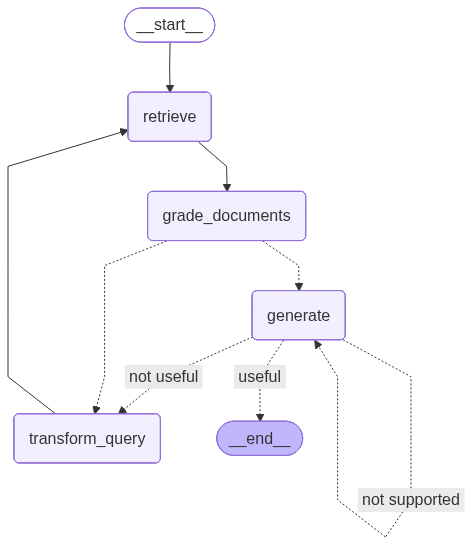

In [11]:
# =============================================================================
# Build Graph
# =============================================================================

def create_self_rag():
    """Build Self-RAG graph."""

    builder = StateGraph(SelfRAGState)

    # Add nodes
    builder.add_node("retrieve", retrieve_node)
    builder.add_node("grade_documents", grade_documents_node)
    builder.add_node("generate", generate_node)
    builder.add_node("transform_query", transform_query_node)

    # Define edges
    builder.add_edge(START, "retrieve")
    builder.add_edge("retrieve", "grade_documents")

    # Conditional edge from grade_documents
    builder.add_conditional_edges(
        "grade_documents",
        decide_to_generate,
        {
            "transform_query": "transform_query",
            "generate": "generate"
        }
    )

    # Transform query loops back to retrieve
    builder.add_edge("transform_query", "retrieve")

    # Conditional edge from generate
    builder.add_conditional_edges(
        "generate",
        grade_generation_v_documents_and_query,
        {
            "not supported": "generate",  # Regenerate (hallucinations)
            "useful": END,  # Success!
            "not useful": "transform_query"  # Rewrite query and retry
        }
    )

    return builder.compile()

graph = create_self_rag()

graph

In [12]:
# =============================================================================
# Demo
# =============================================================================

result = graph.invoke({
    "query": "What was Amazon's revenue in 2023?",
    "rewritten_queries": []
})


[NODE] Retrieve - Fetching documents
[QUERY 1] What was Amazon's revenue in 2023?

[TOOL] retrieve_docs called
[QUERY] What was Amazon's revenue in 2023?
[BM25] Ranked 20 documents by heading+content chunks
  [1] Doc 3: score=29.6385
  [2] Doc 10: score=28.0907
  [3] Doc 2: score=27.3154
  [4] Doc 16: score=25.6818
  [5] Doc 4: score=25.5174
[RETRIEVED] 3 documents
[RETRIEVED] Documents fetched for 1 queries

[NODE] Grade Documents - Evaluating document relevance
[GRADE] Relevance: yes

[ROUTER] Assess graded documents
[DECISION] Have relevant documents - generating answer

[NODE] Generate - Creating answer
[GENERATED] Answer created (1309 chars)

[ROUTER] Check hallucinations and answer quality
[CHECK] Hallucinations
[DECISION] Generation is grounded in documents
[CHECK] Answer quality
[DECISION] Generation addresses query - USEFUL


In [13]:
print(result['generation'])

## Amazon's Revenue in 2023

Amazon's total **revenue (net sales)** for the fiscal year ended December 31, 2023, was **$574.785 billion**. This figure is derived from the consolidated net sales reported in **Note 10 - Segment Information** of Amazon's 2023 10-K filing [1]. 

### Breakdown of Revenue by Segment
- **North America**: $352.828 billion (61% of total revenue)  
- **International**: $131.200 billion (23% of total revenue)  
- **AWS**: $90.757 billion (16% of total revenue)  

### Key Metrics
- **Year-over-Year Growth**: Consolidated revenue increased by **12%** compared to 2022 ($513.983 billion) [3].  
- **Foreign Exchange Impact**: Changes in foreign exchange rates reduced net sales by **$71 million** in 2023, though this effect is typically excluded when analyzing core growth [3].  

### Context
The growth was driven by increased unit sales, particularly from third-party sellers, advertising services, and subscription offerings, as well as expanded shipping and convenience

In [15]:
result = graph.invoke({
    "query": "Compare Apple and Amazon revenue in 2024 q1",
    "rewritten_queries": []
})

print(result['generation'])


[NODE] Retrieve - Fetching documents
[QUERY 1] Compare Apple and Amazon revenue in 2024 q1

[TOOL] retrieve_docs called
[QUERY] Compare Apple and Amazon revenue in 2024 q1
[BM25] Ranked 5 documents by heading+content chunks
  [1] Doc 1: score=25.2225
  [2] Doc 3: score=21.6813
  [3] Doc 0: score=21.6567
  [4] Doc 4: score=18.2055
  [5] Doc 2: score=17.6058
[RETRIEVED] 3 documents
[RETRIEVED] Documents fetched for 1 queries

[NODE] Grade Documents - Evaluating document relevance
[GRADE] Relevance: yes

[ROUTER] Assess graded documents
[DECISION] Have relevant documents - generating answer

[NODE] Generate - Creating answer
[GENERATED] Answer created (1739 chars)

[ROUTER] Check hallucinations and answer quality
[CHECK] Hallucinations
[DECISION] Generation NOT grounded in documents - NOT SUPPORTED (regenerate)

[NODE] Generate - Creating answer
[GENERATED] Answer created (1549 chars)

[ROUTER] Check hallucinations and answer quality
[CHECK] Hallucinations
[DECISION] Generation is ground

In [ ]:
result = graph.invoke({
    "query": "What was Google's revenue in 2023?",
    "rewritten_queries": []
})

print(result['generation'])


[NODE] Retrieve - Fetching documents
[QUERY 1] What was Google's revenue in 2023?

[TOOL] retrieve_docs called
[QUERY] What was Google's revenue in 2023?
[BM25] Ranked 20 documents by heading+content chunks
  [1] Doc 17: score=28.4498
  [2] Doc 14: score=27.2211
  [3] Doc 6: score=27.1219
  [4] Doc 15: score=25.8768
  [5] Doc 2: score=25.8354
[RETRIEVED] 3 documents
[RETRIEVED] Documents fetched for 1 queries

[NODE] Grade Documents - Evaluating document relevance
[GRADE] Relevance: yes

[ROUTER] Assess graded documents
[DECISION] Have relevant documents - generating answer

[NODE] Generate - Creating answer
[GENERATED] Answer created (1266 chars)

[ROUTER] Check hallucinations and answer quality
[CHECK] Hallucinations
[DECISION] Generation is grounded in documents
[CHECK] Answer quality
[DECISION] Generation addresses query - USEFUL


## Google's Revenue in 2023

Google's total revenue for the fiscal year 2023 was **$307,394 million** (or **$307.394 billion**). This figure is derived from the **Consolidated Statements of Income** section of Alphabet Inc.'s 10-K filing for 2023 [3]. 

### Key Details:
- **Revenue Breakdown**: The revenue of **$307,394 million** represents a significant increase compared to the previous year, reflecting growth across Google's core business segments, including advertising, cloud computing, and other services.
- **Context**: This revenue is part of Alphabet Inc.'s consolidated financials, which include Google and its subsidiaries. The 10-K filing provides detailed disclosures about the company's financial performance, including revenue streams and cost structures [3].

### Additional Insights:
- The **income from operations** for 2023 was **$84,293 million**, highlighting the company's profitability after operational expenses [3].
- The **net income** for 2023 was **$73,795 million**, i